# Big Data Cup 2021

The following analysis is done for submission of the big data cup (https://github.com/bigdatacup/Big-Data-Cup-2021). The analysis is less focused on any form of machine learning and more focused on the manipulation and selections of data that we find important and relevant for helping executive understand their players performance. We hope that this analysis can be used in addition to other analytics findings to aid players on the Erie Otters in improving their game performance.

In [2]:
#load in required packages
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
from matplotlib import colors

In [3]:
#set to visualize all columns on output 
pd.set_option('display.max_columns', None)

In [15]:
#load in Erie Otters dataset
url = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv'
df = pd.read_csv(url)
df.head(20)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN
1,2019-09-20,Erie Otters,Sudbury Wolves,1,19:58,5,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,67,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,Emmett Serensits,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74.0,35.0
3,2019-09-20,Erie Otters,Sudbury Wolves,1,19:52,5,5,0,0,Erie Otters,Hayden Fowler,Puck Recovery,89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,Hayden Fowler,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94.0,46.0
5,2019-09-20,Erie Otters,Sudbury Wolves,1,19:48,5,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,64,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-09-20,Erie Otters,Sudbury Wolves,1,19:45,5,5,0,0,Sudbury Wolves,Emmett Serensits,Play,6,60,Indirect,NaN,NaN,NaN,Blake Murray,29.0,2.0
7,2019-09-20,Erie Otters,Sudbury Wolves,1,19:39,5,5,0,0,Sudbury Wolves,Blake Murray,Puck Recovery,59,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-09-20,Erie Otters,Sudbury Wolves,1,19:38,5,5,0,0,Sudbury Wolves,Blake Murray,Play,82,50,Indirect,NaN,NaN,NaN,Owen Gilhula,82.0,54.0
9,2019-09-20,Erie Otters,Sudbury Wolves,1,19:36,5,5,0,0,Sudbury Wolves,Owen Gilhula,Dump In/Out,102,71,Lost,NaN,NaN,NaN,NaN,NaN,NaN


# Finding Possesions

This section focuses on the detection of new possessions throughout the data set. First by locating when the team column changes from the column preceding it, we can detect when puck possession shifts from one team to the other. We also factor in the presence of faceoffs and the reoccurring faceoff recovery regardless of team in order to demonstrate stoppage of plays effecting the overall flow of the possession. The end result of this section is the have the original df labeled with possession IDs.

In [5]:
#altering original dataset, so creating a copy
nopen_df = df.copy()
#creating index column
nopen_df.reset_index(inplace=True)

In [6]:
# Flag whenever 'Team' changes
nopen_df['isTeamChange'] = nopen_df['Team'].shift(1, fill_value=nopen_df['Team'].head(1)) != nopen_df['Team']
nopen_df['isTeamChange'] = np.where(nopen_df['isTeamChange']==True,1,0)

# Flag if a faceoff
nopen_df['isFaceoff'] = np.where(nopen_df['Event']=='Faceoff Win',1,0)

# Flag row after faceoff as start of new possession
nopen_df['recoverFaceoff'] = nopen_df['isFaceoff'].shift(+1)
nopen_df['recoverFaceoff'] = nopen_df['recoverFaceoff'].fillna(0)

# Flag new possessions if 1 in team change or recover faceoff
nopen_df['isNewPoss'] = np.where((nopen_df['isTeamChange']==1)|(nopen_df['recoverFaceoff']==1),1,0)

# Flag new Otter possessions and new opponent possessions separately
nopen_df['newOtterPoss'] = np.where((nopen_df['isNewPoss']==1)&(nopen_df['Team']=='Erie Otters'),1,0)
nopen_df['newOppPoss'] = np.where((nopen_df['isNewPoss']==1)&(nopen_df['Team']!='Erie Otters'),1,0)

# Remove intermediate flag columns
nopen_df = nopen_df.drop(columns=['isTeamChange','isFaceoff','recoverFaceoff','isNewPoss'])

In [7]:
# Make dictionaries of new possessions with original index to map back to original df
otter_pos_dict = pd.Series(nopen_df['newOtterPoss'].values,index=nopen_df['index']).to_dict()
opp_pos_dict = pd.Series(nopen_df['newOppPoss'].values,index=nopen_df['index']).to_dict()

In [8]:
# map new possession dicts back to original df
df['newOtterPoss'] = df.index.map(otter_pos_dict)
df['newOppPoss'] = df.index.map(opp_pos_dict)

In [9]:
#creating date times for relavent columns
df['game_date'] = pd.to_datetime(df['game_date'])
df['Clock'] = pd.to_datetime(df['Clock'],format= '%M:%S' )

#creating possesion IDs off of new otters and new opp flags
df['newPossFlag'] = df['newOtterPoss'] + df['newOppPoss']
df['poss_id'] = df['newPossFlag'].cumsum().fillna(0).astype(int)


# Pass Analysis 

This section focuses on looking at the locational successful passes and failed passes across the rink. The data is segregated by otters plays and every other team. The goal of this section and the next (Visualizing Passing Data) is to understand the locational and situational plotting of passes.

In [10]:
#make copy of df that has possession IDs
pass_goal_df = df.copy()

In [11]:
#remove events that are not primary indicators of play intentions of passing or scoring
pass_goal_df = pass_goal_df[~pass_goal_df['Event'].isin(['Faceoff Win', "Puck Recovery", "Dump In/Out", 
                                                         "Takeaway", 'Penalty Taken', 'Zone Entry'])]
pass_goal_df.drop(['newPossFlag', 'newOtterPoss', 'newOppPoss'], axis =1, inplace = True)

In [12]:
# for easy selections creating a dictionary of dictionaries
# main dict will have a key for play, incomplete play, goal, and shot
#within each dict will have the relevant info for further analysis 

############ creating dictionary ############ 
#split Otters data from all of the opponents
# in this section I pull alot more info than needed, with the hopes of going further with the analysis 
#at a later date

otters_data = {}
opponent_data = {}

########## OTTERS #############
#plays
otters_data['Play'] = {}
otters_data['Play']['Xi'] = [] #x cord of pass
otters_data['Play']['Yi'] = [] #y cord of pass
otters_data['Play']['Xf'] = [] #x end point of pass
otters_data['Play']['Yf'] = [] #y end point of pass
otters_data['Play']["D1"] = [] #direct or indirect
otters_data['Play']['id'] = []
otters_data['Play']['player'] = [] #passer
otters_data['Play']['Team'] = [] 

#incomplete plays
otters_data['Incomplete Play'] = {}
otters_data['Incomplete Play']['Xi'] = []
otters_data['Incomplete Play']['Yi'] = []
otters_data['Incomplete Play']['Xf'] = []
otters_data['Incomplete Play']['Yf'] = []
otters_data['Incomplete Play']["D1"] = [] #direct or indirect
otters_data['Incomplete Play']['id'] = []
otters_data['Incomplete Play']['player'] = [] #passer
otters_data['Incomplete Play']['Team'] = [] 

#shot
otters_data['Shot'] = {}
otters_data['Shot']['Xi'] = []
otters_data['Shot']['Yi'] = []
otters_data['Shot']["D1"] = [] # shot type (Deflection, Fan, Slapshot, Snapshot, Wrap around, Wristshot)
otters_data['Shot']["D2"] = [] # destination (on net, missed, blocked)
otters_data['Shot']["D3"] = [] #trafic (true or false)
otters_data['Shot']["D4"] = [] #one timer (true or fasle)
otters_data['Shot']['id'] = []
otters_data['Shot']['player'] = [] #shooter
otters_data['Shot']['Team'] = [] 

#goal
otters_data['Goal'] = {}
otters_data['Goal']['Xi'] = []
otters_data['Goal']['Yi'] = []
otters_data['Goal']["D1"] = []
otters_data['Goal']["D2"] = []
otters_data['Goal']["D3"] = [] 
otters_data['Goal']["D4"] = [] 
otters_data['Goal']['id'] = []
otters_data['Goal']['player'] = [] #shooter
otters_data['Goal']['Team'] = [] 


########## OPPONENT #############
opponent_data['Play'] = {}
opponent_data['Play']['Xi'] = [] #x cord of pass
opponent_data['Play']['Yi'] = [] #y cord of pass
opponent_data['Play']['Xf'] = [] #x end point of pass
opponent_data['Play']['Yf'] = [] #y end point of pass
opponent_data['Play']["D1"] = [] #direct or indirect
opponent_data['Play']['id'] = []
opponent_data['Play']['player'] = [] #passer
opponent_data['Play']['Team'] = [] 

#incomplete plays
opponent_data['Incomplete Play'] = {}
opponent_data['Incomplete Play']['Xi'] = []
opponent_data['Incomplete Play']['Yi'] = []
opponent_data['Incomplete Play']['Xf'] = []
opponent_data['Incomplete Play']['Yf'] = []
opponent_data['Incomplete Play']["D1"] = [] #direct or indirect
opponent_data['Incomplete Play']['id'] = []
opponent_data['Incomplete Play']['player'] = [] #passer
opponent_data['Incomplete Play']['Team'] = [] 

#shot
opponent_data['Shot'] = {}
opponent_data['Shot']['Xi'] = []
opponent_data['Shot']['Yi'] = []
opponent_data['Shot']["D1"] = [] # shot type (Deflection, Fan, Slapshot, Snapshot, Wrap around, Wristshot)
opponent_data['Shot']["D2"] = [] # destination (on net, missed, blocked)
opponent_data['Shot']["D3"] = [] #trafic (true or false)
opponent_data['Shot']["D4"] = [] #one timer (true or fasle)
opponent_data['Shot']['id'] = []
opponent_data['Shot']['player'] = [] #shooter
opponent_data['Shot']['Team'] = [] 

#goal
opponent_data['Goal'] = {}
opponent_data['Goal']['Xi'] = []
opponent_data['Goal']['Yi'] = []
opponent_data['Goal']["D1"] = []
opponent_data['Goal']["D2"] = []
opponent_data['Goal']["D3"] = [] 
opponent_data['Goal']["D4"] = [] 
opponent_data['Goal']['id'] = []
opponent_data['Goal']['player'] = [] #shooter
opponent_data['Goal']['Team'] = [] 

In [13]:
############ populating dictionary ############ 
#using events from the pass_goal_df
for index, instance in pass_goal_df.iterrows():
    
    play_type = instance["Event"]
    team = instance["Team"]
    
    if team == "Erie Otters":
    
        if play_type == "Play" or play_type == "Incomplete Play":
            otters_data[play_type]['Xi'].append(instance['X Coordinate'])
            otters_data[play_type]['Yi'].append(instance['Y Coordinate'])
            otters_data[play_type]['Xf'].append(instance['X Coordinate 2'])
            otters_data[play_type]['Yf'].append(instance['Y Coordinate 2'])
            otters_data[play_type]["D1"].append(instance['Detail 1'])
            otters_data[play_type]['id'].append(instance['poss_id'])
            otters_data[play_type]['player'].append(instance['Player'])
            otters_data[play_type]['Team'].append(instance['Team'])

        elif play_type == "Shot" or play_type == "Goal":
            otters_data[play_type]['Xi'].append(instance['X Coordinate'])
            otters_data[play_type]['Yi'].append(instance['Y Coordinate'])
            otters_data[play_type]['D1'].append(instance['Detail 1'])
            otters_data[play_type]['D2'].append(instance['Detail 2'])
            otters_data[play_type]["D3"].append(instance['Detail 3'])
            otters_data[play_type]['D4'].append(instance['Detail 4'])
            otters_data[play_type]['id'].append(instance['poss_id'])
            otters_data[play_type]['player'].append(instance['Player'])
            otters_data[play_type]['Team'].append(instance['Team'])
    else:
        
        if play_type == "Play" or play_type == "Incomplete Play":
            opponent_data[play_type]['Xi'].append(instance['X Coordinate'])
            opponent_data[play_type]['Yi'].append(instance['Y Coordinate'])
            opponent_data[play_type]['Xf'].append(instance['X Coordinate 2'])
            opponent_data[play_type]['Yf'].append(instance['Y Coordinate 2'])
            opponent_data[play_type]["D1"].append(instance['Detail 1'])
            opponent_data[play_type]['id'].append(instance['poss_id'])
            opponent_data[play_type]['player'].append(instance['Player'])
            opponent_data[play_type]['Team'].append(instance['Team'])

        elif play_type == "Shot" or play_type == "Goal":
            opponent_data[play_type]['Xi'].append(instance['X Coordinate'])
            opponent_data[play_type]['Yi'].append(instance['Y Coordinate'])
            opponent_data[play_type]['D1'].append(instance['Detail 1'])
            opponent_data[play_type]['D2'].append(instance['Detail 2'])
            opponent_data[play_type]["D3"].append(instance['Detail 3'])
            opponent_data[play_type]['D4'].append(instance['Detail 4'])
            opponent_data[play_type]['id'].append(instance['poss_id'])
            opponent_data[play_type]['player'].append(instance['Player'])
            opponent_data[play_type]['Team'].append(instance['Team'])

# Visualizing Passing Data

This section creates the framework that will be used for the analysis of individual players later on. The final result is a graph with locational successful and failed passes for the Otter and their opponents separately. The size is dependent on the count in that location and the color is dependent on the event type, blue = Play and red = Incomplete play.

In [14]:
# initiating color map details 
ListedColorMap = colors.ListedColormap
to_rgb = colors.ColorConverter().to_rgb

negative_cm = ListedColorMap([to_rgb('#e1e5e5'), to_rgb('#d63b36')])
positive_cm = ListedColorMap([to_rgb('#e1e5e5'), to_rgb('#28aee4')])

In [15]:
# Setting aspect ratio, grid size etc for plots
xbnds = np.array([0,200])
ybnds = np.array([0,200])
extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]

#binning(70)
gridsize= 70;mincnt=0

In [16]:
%%capture 
#supressing output

# use hexbin to bucket plays into 2d histograms
# will seperate plays based on errie vs everyone else

########## OTTERS #############
otter_hex_play = plt.hexbin(otters_data['Play']['Xi'],
                            otters_data['Play']['Yi'],
                            gridsize = gridsize,
                            extent = extent,
                            mincnt = mincnt,
                            alpha = 0)

#extract bin coordinates and counts
otter_verts = otter_hex_play.get_offsets()
otter_play_freq = otter_hex_play.get_array()

#hexbin func for incomplete plays
otter_hex_inc = plt.hexbin(otters_data['Incomplete Play']['Xi'],
                            otters_data['Incomplete Play']['Yi'],
                            gridsize = gridsize,
                            extent = extent,
                            mincnt = mincnt,
                            alpha = 0)
otter_verts1 = otter_hex_inc.get_offsets()
otter_inc_freq = otter_hex_inc.get_array()


########## OPPONENT #############
opp_hex_play = plt.hexbin(opponent_data['Play']['Xi'],
                            opponent_data['Play']['Yi'],
                            gridsize = gridsize,
                            extent = extent,
                            mincnt = mincnt,
                            alpha = 0)

#extract bin coordinates and counts
opp_verts = opp_hex_play.get_offsets()
opp_play_freq = opp_hex_play.get_array()

#hexbin func for incomplete plays
opp_hex_inc = plt.hexbin(opponent_data['Incomplete Play']['Xi'],
                            opponent_data['Incomplete Play']['Yi'],
                            gridsize = gridsize,
                            extent = extent,
                            mincnt = mincnt,
                            alpha = 0)
opp_verts1 = opp_hex_inc.get_offsets()
opp_inc_freq = opp_hex_inc.get_array()


Text(1, -0.1, 'O-Zone')

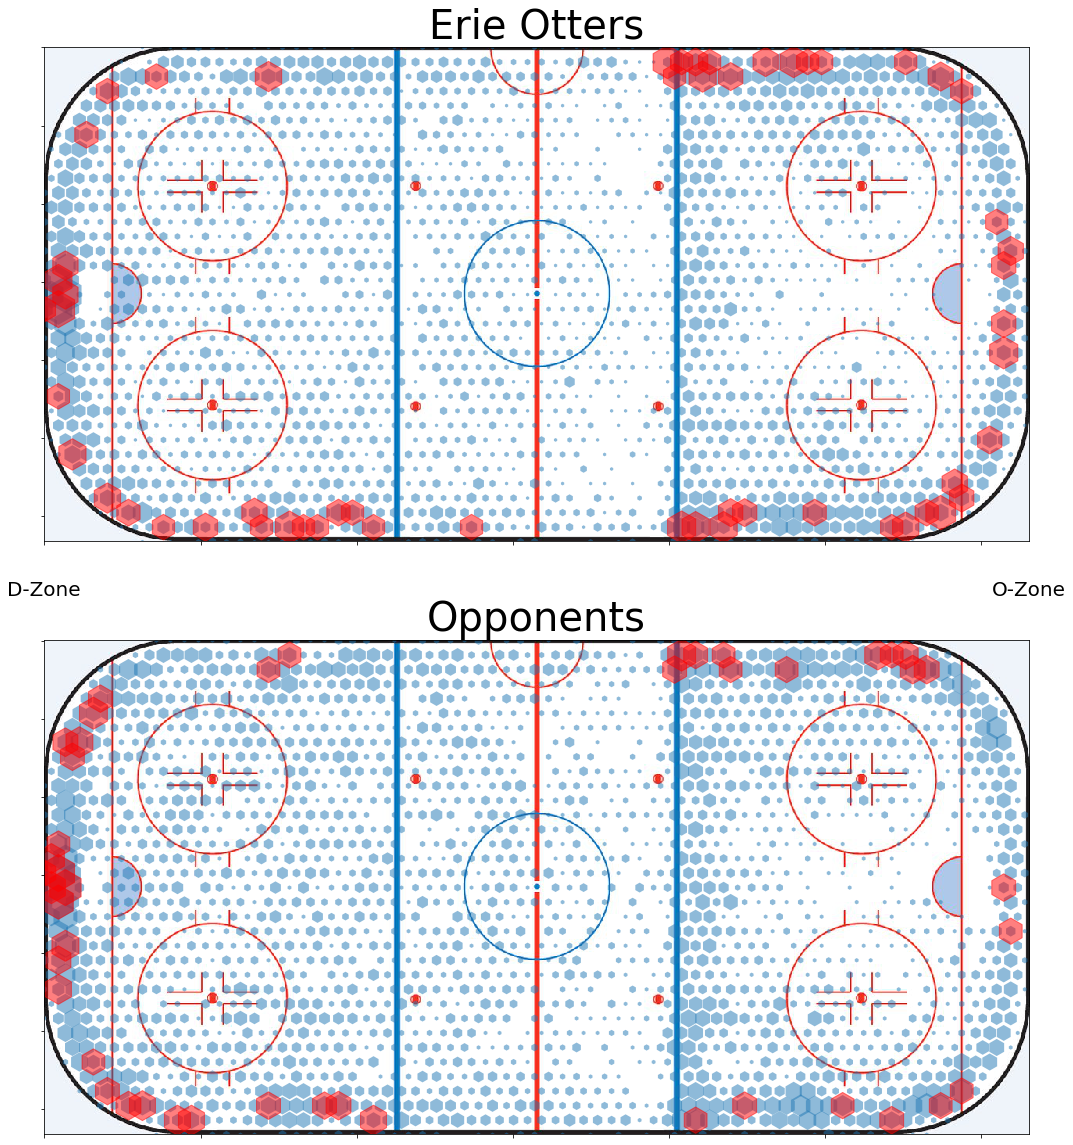

In [17]:

# creating an subplot figure
#one ice rink represents the otter the other the sum of opponents

#creating subplots
fig = plt.figure(figsize= (20,20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#cleaning up figure
ax1.set_facecolor("white")
ax2.set_facecolor("white")
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

#Remove axes labels
ax1.set_xticklabels(labels = [''], fontsize = 18,
   alpha = .1, minor=False)
ax1.set_yticklabels(labels = [''], fontsize = 18,
   alpha = .1, minor=False)

ax2.set_xticklabels(labels = [''], fontsize = 18,
   alpha = .1, minor=False)
ax2.set_yticklabels(labels = [''], fontsize = 18,
   alpha = .1, minor=False)

#import image and image specs
I = Image.open('/Users/christian_petrozza/Desktop/rink_image.png')
width, height = I.size
ax1.imshow(I)
ax2.imshow(I)

#calculate scaling factor and offset
scalex = width/201
scaley=height/85
x_trans =0
y_trans = height

#scales size of hex bins with the image so we calculate a radius scaling factor
S=3.8*scalex

######### plotting hex bins of otters #########
#plays
subplots = [ax1, ax2]

play_dict = {"otter": (otter_verts,otter_play_freq), "opp": (opp_verts,opp_play_freq)}
inc_dict = {"otter": (otter_verts1,otter_inc_freq), "opp": (opp_verts1,opp_inc_freq)}
name_list = ["otter", "opp"]

for a in range(len(subplots)):
    
        # plays
        for i, v in enumerate(play_dict[name_list[a]][0]):

            #ignore empty locations
            if play_dict[name_list[a]][1][i] < 1:
                continue 
            #normalize pass freq between 0-1
            SCALED_FREQUENCY = play_dict[name_list[a]][1][i]/ max(play_dict[name_list[a]][1])

            #scale hex based on shot freq
            radius = S*math.sqrt(SCALED_FREQUENCY)

            #ploy hexagon including the scaling and translations

            hexa = RegularPolygon((x_trans+v[0]*scalex, 
                  y_trans-v[1]*scaley),numVertices=6, radius=radius,
                  orientation=np.radians(0),alpha=0.5, edgecolor=None)
            subplots[a].add_patch(hexa)

        #incomplete
        for i, v in enumerate(inc_dict[name_list[a]][0]):

            #ignore empty locations
            if inc_dict[name_list[a]][1][i] < 10:
                continue 
            #normalize pass freq between 0-1
            SCALED_FREQUENCY = inc_dict[name_list[a]][1][i]/ max(inc_dict[name_list[a]][1])

            #scale hex based on shot freq
            radius = S*math.sqrt(SCALED_FREQUENCY)

            #ploy hexagon including the scaling and translations

            hexa = RegularPolygon((x_trans+v[0]*scalex, 
                  y_trans-v[1]*scaley),numVertices=6, radius=radius,
                  orientation=np.radians(0),alpha=0.5, edgecolor=None, color = "red")
            subplots[a].add_patch(hexa)

ax1.set_title('Erie Otters', fontsize = 40)
ax2.set_title('Opponents', fontsize = 40)

ax1.text(0, -0.1, "D-Zone", fontsize=20,
            horizontalalignment='center', verticalalignment='center', 
            transform=ax1.transAxes)
ax1.text(1, -0.1, "O-Zone", fontsize=20,
            horizontalalignment='center', verticalalignment='center', 
            transform=ax1.transAxes)
    

# Calculating Passer Ratings

#### Reasoning Behind this Approach

This part of the analysis is to calculate a passer rating based on a few metrics that we deem necessary and reproducible. First here is a description of all the metrics we will obtain through the analysis then we will get into how select metrics will be used to calculate a passer rating. This passer rating by no means is a final product but the goal of this is to show that it is possible to create a universal passer rating that is capable of distinguishing players who are both high percentage passers as well as passers who contribute to shots and goals at a higher frequency. 

- pass_succ: Total number of successful passes the player has made over the whole ice surface
- pass_fail: Total number of failed passes the player has made over the whole ice surface
- def_pass_succ: Total number of successful passes that occur in the defensive zone, designated as passes occurring less than 80 on the x coordinate in the original data
- def_pass_fail: Total number of failed passes that occur in the defensive zone, designated as passes occurring less than 80 on the x coordinate in the original data
- off_pass_succ: Total number of successful passes that occur in the offensive zone, designated as passes occurring greater than 120 on the x coordinate in the original data
- off_pass_fail: Total number of failed passes that occur in the offensive zone, designated as passes occurring greater than 120 on the x coordinate in the original data
- Overall_Success_Rate: Total successful passes/ (total successful passes + total failed passes)
- Defense_Success_Rate: Total successful defensive passes/ (total successful defensive passes + total failed defensive passes)
- Offensive_Success_Rate: Total successful offensive passes/ (total successful offensive passes + total failed defensive passes)

##### Passes Leading to Shots/Goals

These next metrics look at the distance of a pass away from the event of a shot or goal. Only looking at instances where between the player passing event and the subsequent shot or goal there are no events that indicate a loss of control during the possession. These events include incomplete plays, dump in/out, and puck recoveries.

- Shot Events
 - one_away_shot: A count of how many passes the player made that was a pass to a shot (aka pass - shot)
 - two_away_shot: A count of how many passes the player made that was a pass to an event to a shot (aka pass - event - shot)
 - three_away_shot: A count of how many passes the player made that was a pass to an event another event to a shot (aka pass - event - event - shot)
 - more_away_shot: A count of how many passes the player made that was a pass to either 4 or five events away from a shot to a shot (aka pass - event - event - event - (event) - shot)
 - shot_rating: a weighted metric placing more weight on pass counts closer to a goal {0.45 : one_away_shot, 0.30 : two_away_shot, 0.15 : three_away_shot, 0.1 : more_away_shot}
 
- Goal Events
 - one_away_goal: A count of how many passes the player made that was a pass to a goal (aka pass - goal)
 - two_away_goal: A count of how many passes the player made that was a pass to an event to a goal (aka pass - event - goal)
 - three_away_goal: A count of how many passes the player made that was a pass to an event another event to a goal (aka pass - event - event - goal)
 - more_away_goal: A count of how many passes the player made that was a pass to either 4 or five events away from a goal (aka pass - event - event - event - (event) - goal)
 - goal_rating: A weighted metric placing more weight on pass counts closer to a goal {0.45 : one_goal_away, 0.30 : two_goal_away, 0.15 : three_away_goal, 0.1 : more_goal_away}}

 
##### Passer Rating Metrics

These formulas were designed in such that majority of each of the three metrics after manipulation are less than 2. The following cumulative passer rating formula is designed to have a maximum value of 100. If any of the following fields (a,b,c) ever exceed 2 they are set to 2 if they are below 0 they are set to 0.

- a: Calculated based on average of the Overall_Success_Rate. The formula is a = (Overall_Success_Rate - 0.32)*4
- b: Calculated with goal_rating*3
- c: Calculated by (shot_rating - 2)/3
- Passer Rating: calculated with the formula Passer Rating = ((a + b + c)/6)*100


In [18]:
### Values for player rating 
#create list of all players (assuming tylers poss_id also works for non eerie players, could just filter later)
players = df.Player[df.Team == "Erie Otters"].unique().tolist()

#get an array of all poss_ids that have a shot or a goal in them
shot_goal_list = df.poss_id[df["Event"].isin(["Shot", "Goal"])].unique()

#create empty dict to store values
pass_rating = {}

#list of events that assume loss of complete control, this will negate importance of a pass
break_list = ["Incomplete Play","Dump In/Out","Puck Recovery"] 

#for loop to itterate over all players in the player list
for player in players:
    #create a temp df with only te player in questions events
    temp_df = df[(df["Player"] == player )]
    
    #add player key to rating dict
    pass_rating[player] = {}
    
    #simple metrics
    pass_succ = len(temp_df[temp_df["Event"] == "Play"]) #succesful passes
    pass_fail = len(temp_df[temp_df["Event"] == "Incomplete Play"]) #failed passes
    def_pass_succ = len(temp_df[(temp_df["Event"] == "Play") & (temp_df["X Coordinate"] <= 80)]) #successfull D passes
    off_pass_succ = len(temp_df[(temp_df["Event"] == "Play") & (temp_df["X Coordinate"] >= 120)]) # successfull O passes
    def_pass_fail = len(temp_df[(temp_df["Event"] == "Incomplete Play") & (temp_df["X Coordinate"] <= 80)])
    off_pass_fail = len(temp_df[(temp_df["Event"] == "Incomplete Play") & (temp_df["X Coordinate"] >= 80)])
    
    #set passes x events away from pass to 0 for player
    one_away_shot = 0
    two_away_shot = 0
    three_away_shot = 0
    more_away_shot = 0
    one_away_goal = 0
    two_away_goal = 0
    three_away_goal = 0
    more_away_goal = 0
    
    #for loop to go through all the possessions that the player of interest has been apart of
    for poss in temp_df["poss_id"].unique():
        #check if possesion has a shot or a goal in it
        if poss in shot_goal_list:
            #create holder df that as all the events within the possessions that has a shot/goal and the player present
            holder_df = df[df["poss_id"] == poss]
            #reset the index so iloc works
            holder_df.index = list(range(len(holder_df)))

            #get index value in a list for every time a shot or goal occurs in the possession
            shots_in_play = holder_df.index[holder_df.Event == "Shot"].tolist()
            goals_in_play = holder_df.index[holder_df.Event == "Goal"].tolist()
            #get index value in a list for every time a pass occurs from player in question
            passes_in_play = holder_df.index[(holder_df.Player == player) & (holder_df.Event == "Play")].tolist()
            
            #for loop to go through every pass the player makes during the possession
            for pas in passes_in_play:
            #since we dont know where the pass occurs in the play need to check if indexing
            #will go ou of bounds, that is why we have these gross if statments for every
            #dstance away from a passing event
                #event one away from pass
                if (pas+1) <= (len(holder_df)-1):
                    #if the event is in breaklist move to next pass in possession
                    if holder_df.iloc[pas+1]["Event"] in break_list:
                        continue
                    #if pass is a shot add to shot counter
                    elif holder_df.iloc[pas+1]["Event"] == "Shot":
                        one_away_shot += 1
                        continue #move to next pass in possession 
                        #this method can cause some problems ie if it goes shot goal (in the case of a rebound)
                    elif holder_df.iloc[pas+1]["Event"] == "Goal":
                        one_away_goal +=1
                        continue
                        
                if (pas+2) <= (len(holder_df)-1):
                    if (holder_df.iloc[pas+1]["Event"] in break_list or
                        holder_df.iloc[pas+2]["Event"] in break_list):
                        continue 
                    elif holder_df.iloc[pas+2]["Event"] == "Shot":
                        two_away_shot += 1
                    elif holder_df.iloc[pas+2]["Event"] == "Goal":
                        two_away_goal +=1
                        continue

                if (pas+3) <= (len(holder_df)-1):
                    if (holder_df.iloc[pas+1]["Event"] in break_list or
                        holder_df.iloc[pas+2]["Event"] in break_list or 
                        holder_df.iloc[pas+3]["Event"] in break_list):
                        continue 
                    elif holder_df.iloc[pas+3]["Event"] == "Shot":
                        three_away_shot += 1
                        continue
                    elif holder_df.iloc[pas+3]["Event"] == "Goal":
                        three_away_goal += 1
                        continue 
                        
                if (pas+4) <= (len(holder_df)-1):
                    if (holder_df.iloc[pas+1]["Event"] in break_list or
                        holder_df.iloc[pas+2]["Event"] in break_list or 
                        holder_df.iloc[pas+3]["Event"] in break_list or
                        holder_df.iloc[pas+4]["Event"] in break_list):
                        continue 
                    elif holder_df.iloc[pas+4]["Event"] == "Shot":
                        more_away_shot += 1
                        continue
                    elif holder_df.iloc[pas+4]["Event"] == "Goal":
                        more_away_goal +=1
                        continue
                        
                if (pas+5) <= (len(holder_df)-1):
                    if (holder_df.iloc[pas+1]["Event"] in break_list or
                        holder_df.iloc[pas+2]["Event"] in break_list or 
                        holder_df.iloc[pas+3]["Event"] in break_list or
                        holder_df.iloc[pas+4]["Event"] in break_list or
                        holder_df.iloc[pas+5]["Event"] in break_list):
                        continue 
                    elif holder_df.iloc[pas+5]["Event"] == "Shot":
                        more_away_shot += 1
                        continue
                    elif holder_df.iloc[pas+5]["Event"] == "Goal":
                        more_away_goal +=1
                        continue
                        
    #add to dict of player                    
    pass_rating[player]['pass_succ'] = pass_succ
    pass_rating[player]['pass_fail'] = pass_fail
    pass_rating[player]['def_pass_succ'] = def_pass_succ
    pass_rating[player]['off_pass_succ'] = off_pass_succ
    pass_rating[player]['def_pass_fail'] = def_pass_fail
    pass_rating[player]['off_pass_fail'] = off_pass_fail
    pass_rating[player]['one_away_shot'] = one_away_shot
    pass_rating[player]['two_away_shot'] = two_away_shot
    pass_rating[player]['three_away_shot'] = three_away_shot
    pass_rating[player]['more_away_shot'] = more_away_shot
    pass_rating[player]['one_away_goal'] = one_away_goal
    pass_rating[player]['two_away_goal'] = two_away_goal
    pass_rating[player]['three_away_goal'] = three_away_goal
    pass_rating[player]['more_away_goal'] = more_away_goal

In [19]:
#generating metrics summary statistics and overall Passer Rating

pass_rating_df = pd.DataFrame(pass_rating)
pass_rating_df = pass_rating_df.T
pass_rating_df['Overall_Success_Rate'] = pass_rating_df.pass_succ/(pass_rating_df.pass_succ + pass_rating_df.pass_fail)
pass_rating_df['Defense_Success_Rate'] = pass_rating_df.def_pass_succ/(pass_rating_df.def_pass_succ + pass_rating_df.def_pass_fail)
pass_rating_df['Offensive_Success_Rate'] = pass_rating_df.off_pass_succ/(pass_rating_df.off_pass_succ + pass_rating_df.off_pass_fail)
pass_rating_df["goal_rating"] = ((pass_rating_df.one_away_goal*0.45 + pass_rating_df.two_away_goal*0.30 +
                                pass_rating_df.three_away_goal*0.15 + pass_rating_df.more_away_goal*0.1)/ (pass_rating_df.pass_succ + 
                                                                                                           pass_rating_df.pass_fail))*100

pass_rating_df["shot_rating"] = ((pass_rating_df.one_away_shot*0.45 + pass_rating_df.two_away_shot*0.30 +
                                pass_rating_df.three_away_shot*0.15 + pass_rating_df.more_away_shot*0.1)/ (pass_rating_df.pass_succ +
                                                                                                          pass_rating_df.pass_fail))*100

#calculating metrics for passer rating
#calcualting overall passing matric (aka a)
pass_rating_df["a"] = (pass_rating_df.Overall_Success_Rate - 0.32)*4
#chage all values greater than 2 to 2 and ess than 0 to 0
pass_rating_df.a = pass_rating_df.a.apply(lambda x: np.where(x >= 2.0, 2.0,x))
pass_rating_df.a = pass_rating_df.a.apply(lambda x: np.where(x <= 0, 0,x))

#calc pass/goal metric
pass_rating_df["b"] =  pass_rating_df["goal_rating"] * 3
pass_rating_df.b = pass_rating_df.b.apply(lambda x: np.where(x >= 2.0, 2.0,x))
pass_rating_df.b = pass_rating_df.b.apply(lambda x: np.where(x <= 0, 0,x))

#calc shot?pass metric
pass_rating_df["c"] = (pass_rating_df["shot_rating"] -2)/3
pass_rating_df.c = pass_rating_df.c.apply(lambda x: np.where(x >= 2.0, 2.0,x))
pass_rating_df.c = pass_rating_df.c.apply(lambda x: np.where(x <= 0, 0,x))




pass_rating_df["Passer Rating"] = ((pass_rating_df["a"]+pass_rating_df["b"]+pass_rating_df["c"])/6)*100

        
        


In [27]:
pass_analysis = pd.DataFrame(pass_rating_df[["Passer Rating", "Overall_Success_Rate"]])
pass_analysis.sort_values(by='Passer Rating', ascending = False)[:10]

,Passer Rating,Overall_Success_Rate
Maxim Golod,95.762468,0.756437
Kyen Sopa,91.501385,0.756233
Chad Yetman,89.120141,0.779152
Danial Singer,87.052411,0.702830
Brendan Sellan,84.259508,0.711409
Jamie Drysdale,84.011453,0.810308
Connor Lockhart,82.241240,0.694136
Daniel D'Amato,80.863955,0.674614
Brendan Hoffmann,79.719751,0.694391
Matthew MacDougall,78.502463,0.738916


In [22]:
#create lis of top 5 players on the otters to visualize there efficiency against the league
top_5 = pass_rating_df.sort_values(by='Passer Rating', ascending = False).index.values[0:5].tolist()
bottom_5 =  pass_rating_df.sort_values(by='Passer Rating').index.values[0:5].tolist()
bottom_5

['Brett Bressette',
 'Christian Kyrou',
 'Aidan Campbell',
 'Daniel Murphy',
 'Cameron Morton']

# Individual Player Locational Passing Efficiency

Using the same method of locational binning above we will now only select players that were top 5 in passing rating to examine how these passer ratings are broken down on a lactational basis. Looking at where players may be either above or below the league averages in locations around the ice. The grid mapping in these plots however points are scaled based on their locational frequency but coloured by their relative efficiency. The bluer a point demonstrates the more effective they are in that location of the ice in comparison to the league average. The redder the point is means that they are far below the league average in that location. Each point demonstrates their passing efficiency in that location (ie successful passes/ total passes)

In [24]:
%%capture
# calculating a league efficiency 
league_efficiency = [] # locational efficiency of whole league 
player_efficiency = {} # Player based locational efficiency
relative_efficiency = {} # Relative efficiency based on locational league and locational player

complete_data = {}
complete_data["Play"] = {}
complete_data['Incomplete Play'] = {}
complete_data["Play"]["Xi"] = otters_data['Play']['Xi'] + opponent_data['Play']['Xi']
complete_data["Play"]["Yi"] = otters_data['Play']['Yi'] + opponent_data['Play']['Yi']
complete_data['Incomplete Play']["Xi"] = otters_data['Incomplete Play']['Xi'] + opponent_data['Incomplete Play']['Xi']
complete_data['Incomplete Play']["Yi"] = otters_data['Incomplete Play']['Yi'] + opponent_data['Incomplete Play']['Yi']

#redo 2D histograms with the complete league data for plays and incomplete plays
league_hex_play = plt.hexbin(complete_data['Play']['Xi'],
                            complete_data['Play']['Yi'],
                            gridsize = gridsize,
                            extent = extent,
                            mincnt = mincnt,
                            alpha = 0)

#extract bin coordinates and counts
league_verts = league_hex_play.get_offsets()
league_play_freq = league_hex_play.get_array()

#hexbin func for incomplete plays
league_hex_inc = plt.hexbin(complete_data['Incomplete Play']['Xi'],
                            complete_data['Incomplete Play']['Yi'],
                            gridsize = gridsize,
                            extent = extent,
                            mincnt = mincnt,
                            alpha = 0)
league_verts1 = league_hex_inc.get_offsets()
league_inc_freq = league_hex_inc.get_array()


In [25]:
# calculate the locational efficency of the league
for i in range(0, len(league_play_freq)):
    
    #filter out areas of ice where league freq is less than 1
    if league_play_freq[i] < 1:
        continue 
    league_efficiency.append(league_play_freq[i]/(league_play_freq[i] + league_inc_freq[i]))
    
    max_league_efficiency = max(league_efficiency)

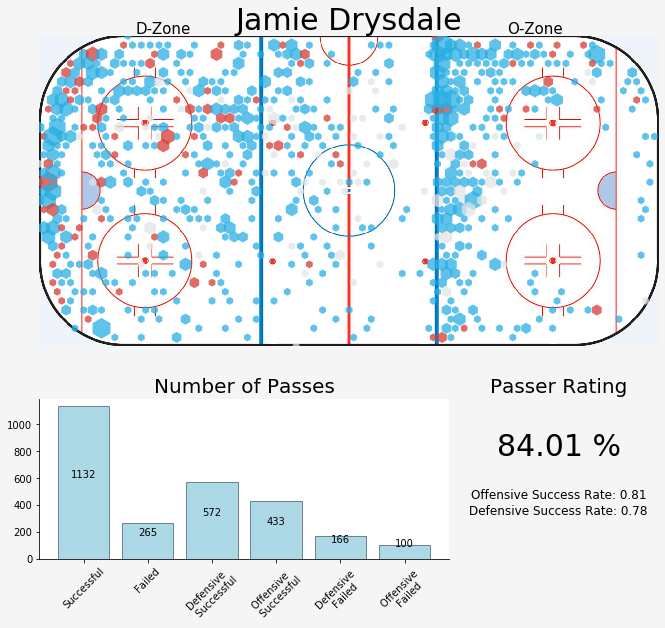

In [26]:
#testing grid spec
from os import path 
outpath ='/Users/christian_petrozza/Desktop/Player Efficiencies/'

I = Image.open('/Users/christian_petrozza/Desktop/rink_image.png')
width, height = I.size
scalex = width/200
scaley=height/85
x_trans =0
y_trans = height

S=3.8*scalex

#doing a player specific analysis 
for player in top_5:
    
    fig8 = plt.figure(figsize = (20,10))
    gs1 = fig8.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.05)
    f8_ax1 = fig8.add_subplot(gs1[:-1, :])
    f8_ax2 = fig8.add_subplot(gs1[-1, :-1])
    f8_ax3 = fig8.add_subplot(gs1[-1, -1])
    
    
    #make fgure blank
    f8_ax1.set_facecolor("white")
    fig8.patch.set_facecolor('whitesmoke')

    #Remove axes labels
    f8_ax1.set_xticklabels(labels = [''], fontsize = 18,
       alpha = .7, minor=False)
    f8_ax1.set_yticklabels(labels = [''], fontsize = 18,
       alpha = .7, minor=False)
    
    f8_ax1.imshow(I)
    

    player_df = pd.DataFrame(otters_data["Play"])
    player_df = player_df[player_df['player'] == player]
    player_x = list(player_df['Xi'])
    player_y = list(player_df['Yi'])

    player_df_inc = pd.DataFrame(otters_data["Incomplete Play"])
    player_df_inc = player_df_inc[player_df_inc['player'] == player]
    player_x_inc = list(player_df_inc['Xi'])
    player_y_inc = list(player_df_inc['Yi'])

    player_hex_play = plt.hexbin(player_x,
                            player_y,
                            gridsize = gridsize,
                            extent = extent,
                            mincnt = mincnt,
                            alpha = 0)
    #extract bin coordinates and counts
    player_verts = player_hex_play.get_offsets()
    player_play_freq = player_hex_play.get_array()

    #hexbin func for incomplete plays
    player_hex_inc = plt.hexbin(player_x_inc,
                                player_y_inc,
                                gridsize = gridsize,
                                extent = extent,
                                mincnt = mincnt,
                                alpha = 0)
    player_verts1 = player_hex_inc.get_offsets()
    player_inc_freq = player_hex_inc.get_array()

    for i, v in enumerate(player_verts):

        if player_play_freq[i]<1:
            continue 

        #scsaling freq
        scaled_player_freq = player_play_freq[i]/max(player_play_freq)

        #radius of hex
        radius = S*math.sqrt(scaled_player_freq)       

        #relative efficiency
        player_effic = player_play_freq[i]/(player_play_freq[i] + player_inc_freq[i])
        league_effic = league_play_freq[i]/(league_play_freq[i] + league_inc_freq[i])

        rel_efficiency = player_effic - league_effic

        #finding positive/negaive efficiencies
        if rel_efficiency > 0:
            colour = positive_cm(math.pow(rel_efficiency,0.1))
        else:
            colour = negative_cm(math.pow(-rel_efficiency,0.1))

        #plottig locational efficiency

        hexa = RegularPolygon((x_trans+v[0]*scalex,
           y_trans-v[1]*scaley),numVertices=6, radius=radius,
           orientation=np.radians(0),facecolor=colour,alpha=0.75,
           edgecolor=None)
        
        f8_ax1.add_patch(hexa)

    f8_ax1.set_title(player, fontsize = 30)
    f8_ax1.set_xticks([])
    f8_ax1.set_yticks([])
    f8_ax1.spines['top'].set_visible(False)
    f8_ax1.spines['right'].set_visible(False)
    f8_ax1.spines['left'].set_visible(False)
    f8_ax1.spines['bottom'].set_visible(False)
    
    f8_ax1.text(0.2, 1.02, "D-Zone", fontsize=15,
            horizontalalignment='center', verticalalignment='center', 
            transform=f8_ax1.transAxes)
    f8_ax1.text(0.8, 1.02, "O-Zone", fontsize=15,
            horizontalalignment='center', verticalalignment='center', 
            transform=f8_ax1.transAxes)
    

    ######### plotting bar graph ############
    
    labels = ["Successful", 'Failed','Defensive \n Successful', 'Offensive \n Successful', 
         'Defensive \n Failed', 'Offensive \n Failed']
    
    person = pass_rating_df[pass_rating_df.index == player]
    person = person[["pass_succ", 'pass_fail','def_pass_succ', 'off_pass_succ', 
                     'def_pass_fail', 'off_pass_fail']]
    data = person.values.tolist()[0]
    
    location = f8_ax2.bar(labels, data, color ='lightblue', edgecolor = "slategray")
    f8_ax2.set_xticklabels(labels, rotation = 45)
    f8_ax2.set_title("Number of Passes", fontsize = 20)
    
    def autolabel(rects):
    #"""Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            f8_ax2.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height/2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(location)
    
    f8_ax2.spines['top'].set_visible(False)
    f8_ax2.spines['right'].set_visible(False)
    
    ####### puting overall Passer Rating ###########
    f8_ax3.set_title("Passer Rating", fontsize = 20)
    f8_ax3.set_xticks([])
    f8_ax3.set_yticks([])
    
    passer_rating = pass_rating_df["Passer Rating"][pass_rating_df.index == player].values[0].round(2)
    offensive_rate = pass_rating_df["Offensive_Success_Rate"][pass_rating_df.index == player].values[0].round(2)
    defensive_rate = pass_rating_df["Defense_Success_Rate"][pass_rating_df.index == player].values[0].round(2)
    
    f8_ax3.text(0.5, 0.7, '{} %'.format(passer_rating), fontsize=30,
                horizontalalignment='center', verticalalignment='center', 
                transform=f8_ax3.transAxes)
    
    f8_ax3.text(0.5, 0.4, 'Offensive Success Rate: {}'.format(offensive_rate), fontsize=12,
                horizontalalignment='center', verticalalignment='center', 
                transform=f8_ax3.transAxes)
    f8_ax3.text(0.5, 0.3, 'Defensive Success Rate: {}'.format(defensive_rate), fontsize=12,
            horizontalalignment='center', verticalalignment='center', 
            transform=f8_ax3.transAxes)
    
    f8_ax3.spines['top'].set_visible(False)
    f8_ax3.spines['right'].set_visible(False)
    f8_ax3.spines['left'].set_visible(False)
    f8_ax3.spines['bottom'].set_visible(False)
    
    f8_ax3.set_facecolor('whitesmoke')
    
    #fig.savefig(path.join(outpath,(player+".png")), facecolor='w', edgecolor='w',)
    
                     

